<a href="https://colab.research.google.com/github/DanielRabinovitz/pokemon_classifier/blob/main/pokemon_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
#get data
import pandas as pd

dataset_url = 'https://raw.githubusercontent.com/DanielRabinovitz/pokemon_classifier/main/pokemondata_clean.csv'
df = pd.read_csv(dataset_url)

placeholder = df.loc[:, 'defense_vs_normal':'defense_vs_fairy']
placeholder2 = df.loc[:, 'offense_vs_bug': 'offense_vs_water']
cols = placeholder.columns.append(placeholder2.columns)
for col in cols:
  df.pop(col)
df.pop('Unnamed: 0')
df.head()

,Rank,numbered_rank,name,abilities,typing,hp,attack,defense,special_attack,special_defense,speed,bst,ttd,tto
0,RUBL,3.5,Venusaur,Overgrow~Chlorophyll,Grass~Poison,80,82,83,100,100,80,525,19.25,22.0
1,PU,1.0,Charizard,Blaze~Solar Power,Fire~Flying,78,84,78,109,85,100,534,18.50,22.5
2,NU,2.0,Blastoise,Torrent~Rain Dish,Water,79,83,100,85,105,78,530,18.00,19.5
3,(PU),0.0,Butterfree,Compound Eyes~Tinted Lens,Bug~Flying,60,45,50,90,80,70,395,22.00,22.5
4,(PU),0.0,Raichu,Static~Lightning Rod,Electric,60,90,55,90,80,110,485,17.50,17.5


In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


#short for pokemon, is X
poke = df.loc[:, 'hp':'tto']
#is Y
rank = df['Rank']

#split data
poke_train, poke_test, rank_train, rank_test = train_test_split(poke, rank, test_size = 0.3)

#loop over trees to see accuracy
#accuracy_dict stores n_estimators and accuracy for the plot later
accuracy_dict={0:0}
indexer = 1
for k in range(25):
  #viridian forest is a location in the pokemon games
  viridian_forest = RandomForestClassifier(n_estimators  = k+1)
  viridian_forest.fit(poke_train, rank_train)
  rank_pred = viridian_forest.predict(poke_test)
  #store accuracy and index
  accuracy_dict[indexer] = metrics.accuracy_score(rank_pred, rank_test)
  #increment index
  indexer+=1

0.40638606676342526


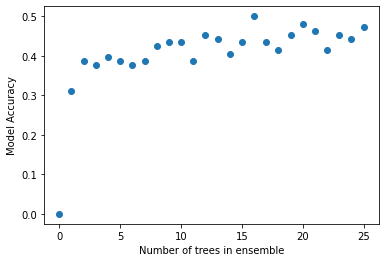

In [214]:
import matplotlib.pyplot as plt
import statistics

#plot num_trees vs accuracy
i = list(accuracy_dict.keys())
v = list(accuracy_dict.values())
plt.scatter(i, v)
plt.xlabel('Number of trees in ensemble')
plt.ylabel('Model Accuracy')
print(statistics.mean(v))


In [173]:
import pandas as pd
type_mat_url = 'https://raw.githubusercontent.com/DanielRabinovitz/pokemon_classifier/main/type_matrix.csv'
type_matrix = pd.read_csv(type_mat_url)

#list of types in order
type_list = ['bug', 'dark', 'dragon', 
         'electric', 'fairy', 'fighting',
         'fire', 'flying', 'ghost',
         'grass', 'ground', 'ice',
         'normal', 'poison', 'psychic',
         'rock', 'steel', 'water']

#function to return tto of a type combo
def offensive_calcs(type_string):

  type_string = type_string.lower()

  #dual types have a ~ seperator
  if('~' in type_string):
    #seperate types using partition
    types = type_string.partition('~')
    type1 = types[0]
    type2 = types[2]

    #get vector of attack multipliers from type_matrix for each type
    type_1_numbers = type_matrix[type1]
    type_2_numbers = type_matrix[type2]
    
    #placeholder list of merger
    merged_numbers = []
    
    #at each type compare the two lists, picking the bigger number each time
    #there are 18 types, each list is 18 long
    for i in range(18):
      merged_numbers.append(max(type_1_numbers[i], type_2_numbers[i]))

    return sum(merged_numbers)

  #for a single type just return its attack multiplier column
  else:
    return sum(type_matrix[type_string])

#function to return ttd of a type combo
def defensive_calcs(type_string):

  type_string = type_string.lower()

  #dual types have a ~ seperator
  if('~' in type_string):
    #seperate types using partition
    types = type_string.partition('~')
    type1 = types[0]
    type2 = types[2]

    #get vector of defense multipliers from type_matrix for each type
    type_1_numbers = type_matrix.loc[type_matrix['type']==type1]
    #get index of row in the type matrix
    type_1_index = type_list.index(type1)
    type_2_numbers = type_matrix.loc[type_matrix['type']==type2]
    type_2_index = type_list.index(type2)
    #get rid of type name
    type_1_numbers.pop('type')
    type_2_numbers.pop('type')
    
    #placeholder list of merger
    merged_numbers = []
    
    #at each type compare the two lists, picking the bigger number each time
    #there are 18 types, each list is 18 long
    for i in type_list:
      merged_numbers.append(type_1_numbers.at[type_1_index, i]*type_2_numbers.at[type_2_index, i])

    return sum(merged_numbers)

  #for a single type just return its attack multiplier column
  else:
    #get defensive multipliers as a row of type_matrix
    row = type_matrix.loc[type_matrix['type']==type_string]
    #get index of the type's row
    type_index = type_list.index(type_string)
    row.pop('type')
    #s short for sum
    s = 0
    for i in type_list:
      s += row.at[type_index, i]
    return s

#make function to turn a hypothetical pokemon into a dataframe row 
def poke_maker(name, typing, hp, atk, physdef, spatk, spdef, speed):
  tto = offensive_calcs(typing)
  ttd = defensive_calcs(typing)
  bst = hp+atk+physdef+spatk+spdef+speed
  data = {'name':[name], 'typing':[typing],	'hp':[hp], 'attack':[atk], 'defense':[physdef], 'special_attack':[spatk], 
          'special_defense':[spdef], 'speed':[speed], 'bst':[bst], 'ttd':[ttd],	'tto':[tto]}
  poke = pd.DataFrame(data)
  return poke

#limits attributes for the classifier-relevant ones
def poke_prep(poke):
  return poke.loc[:, 'hp':'tto']

def add_rank(poke, classifier):
  rank = classifier.predict(poke_prep(poke))
  poke.insert(0, 'precicted_rank', rank)

def rank_poke(name, typing, hp, atk, physdef, spatk, spdef, speed):
  poke = poke_maker(name, typing, hp, atk, physdef, spatk, spdef, speed)
  add_rank(poke, viridian_forest)
  return poke


Mean importance of bst : 0.1652862197648908
Mean importance of special_attack : 0.1162301919279893
Mean importance of speed : 0.11522889901574893
Mean importance of attack : 0.11123302288545026
Mean importance of hp : 0.10659733655555893
Mean importance of ttd : 0.10349556070581963
Mean importance of tto : 0.09754556999072574
Mean importance of defense : 0.09383758796796822
Mean importance of special_defense : 0.09054561118584772


Text(0.5, 1.0, 'Average attribute importance over 1000 trials')

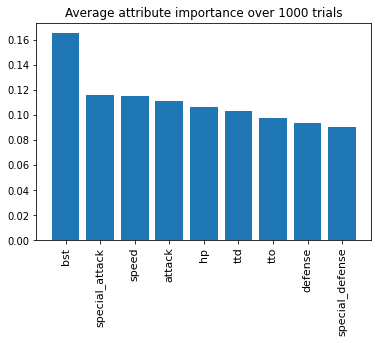

In [206]:
import statistics

cols = list(poke.columns)
#dataframe of feature_importances
feature_importances = pd.DataFrame(columns = cols)

for i in range(1000):
  #split data
  poke_train, poke_test, rank_train, rank_test = train_test_split(poke, rank, test_size = 0.3)

  #make new classifier to rank hand-evaluated data
  viridian_forest = RandomForestClassifier(n_estimators  = 25)
  viridian_forest.fit(poke_train, rank_train)
  rank_pred = viridian_forest.predict(poke_test)

  #add the importances from this classifier to the dataframe of importances
  feature_importances.loc[len(feature_importances)] = list(viridian_forest.feature_importances_)

#dict to store features, list to rank features
importances_dict = {}
ranking_list = []
for col_name in cols:
  #all numbers in feature
  feature_mean = feature_importances[col_name].mean()
  #using mean as key for sorting later
  importances_dict[feature_mean]=col_name
  ranking_list.append(feature_mean)

ranking_list.sort(reverse=True)
x=[]
y=[]
for num in ranking_list:
  print('Mean importance of', importances_dict[num], ':', num)
  x.append(importances_dict[num])
  y.append(num)

import matplotlib.pyplot as plt
plt.bar(x,y)
plt.xticks(rotation=90, fontsize=11)
plt.title('Average attribute importance over 1000 trials')



In [ ]:
'''
#make new classifier to rank hand-evaluated data
viridian_forest = RandomForestClassifier(n_estimators  = 1000)
viridian_forest.fit(poke_train, rank_train)
rank_pred = viridian_forest.predict(poke_test)

#show feature weights in order from greatest to least
#make dict to call lists later
feature_dict = {}
for i in range(len(poke.columns)):
  feature_dict[viridian_forest.feature_importances_[i]] = poke.columns[i]
'''

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
df_col = pd.DataFrame(columns)
df_col.append(x)
df_col

In [ ]:
#reference for function header
#rank_poke(name, typing, hp, atk, physdef, spatk, spdef, speed)



#existing pokemon not in gen 8, should be OU or UU
manaphy = rank_poke('Manaphy', 'Water', 100,100,100,100,100,100)
#fake overpowered pokemon, should be Ubers
uberzard = rank_poke('Uberzard', 'Ghost~Normal', 65, 200, 50, 200, 50, 150)
#really bad pokemon, should be untiered
horribug = rank_poke('Horribug', 'Bug~Flying', 50,50,50,50,50,50)

#mediocre mon, should go in NU. P is physical and S is special
mediogre_phys = rank_poke('Mediogre-P', 'Poison~Fighting', 70, 110, 70, 50, 70, 100)
mediogre_spa = rank_poke('Mediogre-S', 'Poison~Fighting', 70, 50, 70, 110, 70, 100)
#classifier has a BIG special bias

#tanky mon, should be UU at least
defendoor = rank_poke('Defendoor', 'Steel', 100, 40, 120, 40, 120, 40)
#classifier ranks it low, does not understand bulk

#Should rank untiered
balanpsy = rank_poke('Balanpsy', 'Psychic', 90,90,90,90,90,90)

#Should rank fairly high with a great typing
mechanifey = rank_poke('Mechanifey', 'Steel~Fairy', 90,90,90,90,90,90)

print(manaphy)
print(uberzard)
print(horribug)
print(mediogre_phys)
print(mediogre_spa)
print(defendoor)
print(balanpsy)
print(mechanifey)
